In [1]:
!pip install shap


     -------------------------------------- 544.4/544.4 kB 2.4 MB/s eta 0:00:00
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
     ---------------------------------------- 2.8/2.8 MB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 30.3/30.3 MB 8.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import shap
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [3]:
df=pd.read_csv("../../media/data/stroke.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
df=df.drop('id',axis=1)

In [5]:
df=df.dropna()
df['age']=df['age'].astype(np.int64)


In [6]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [7]:
le=LabelEncoder()
for col in ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]:
    df[col] = le.fit_transform(df[col])

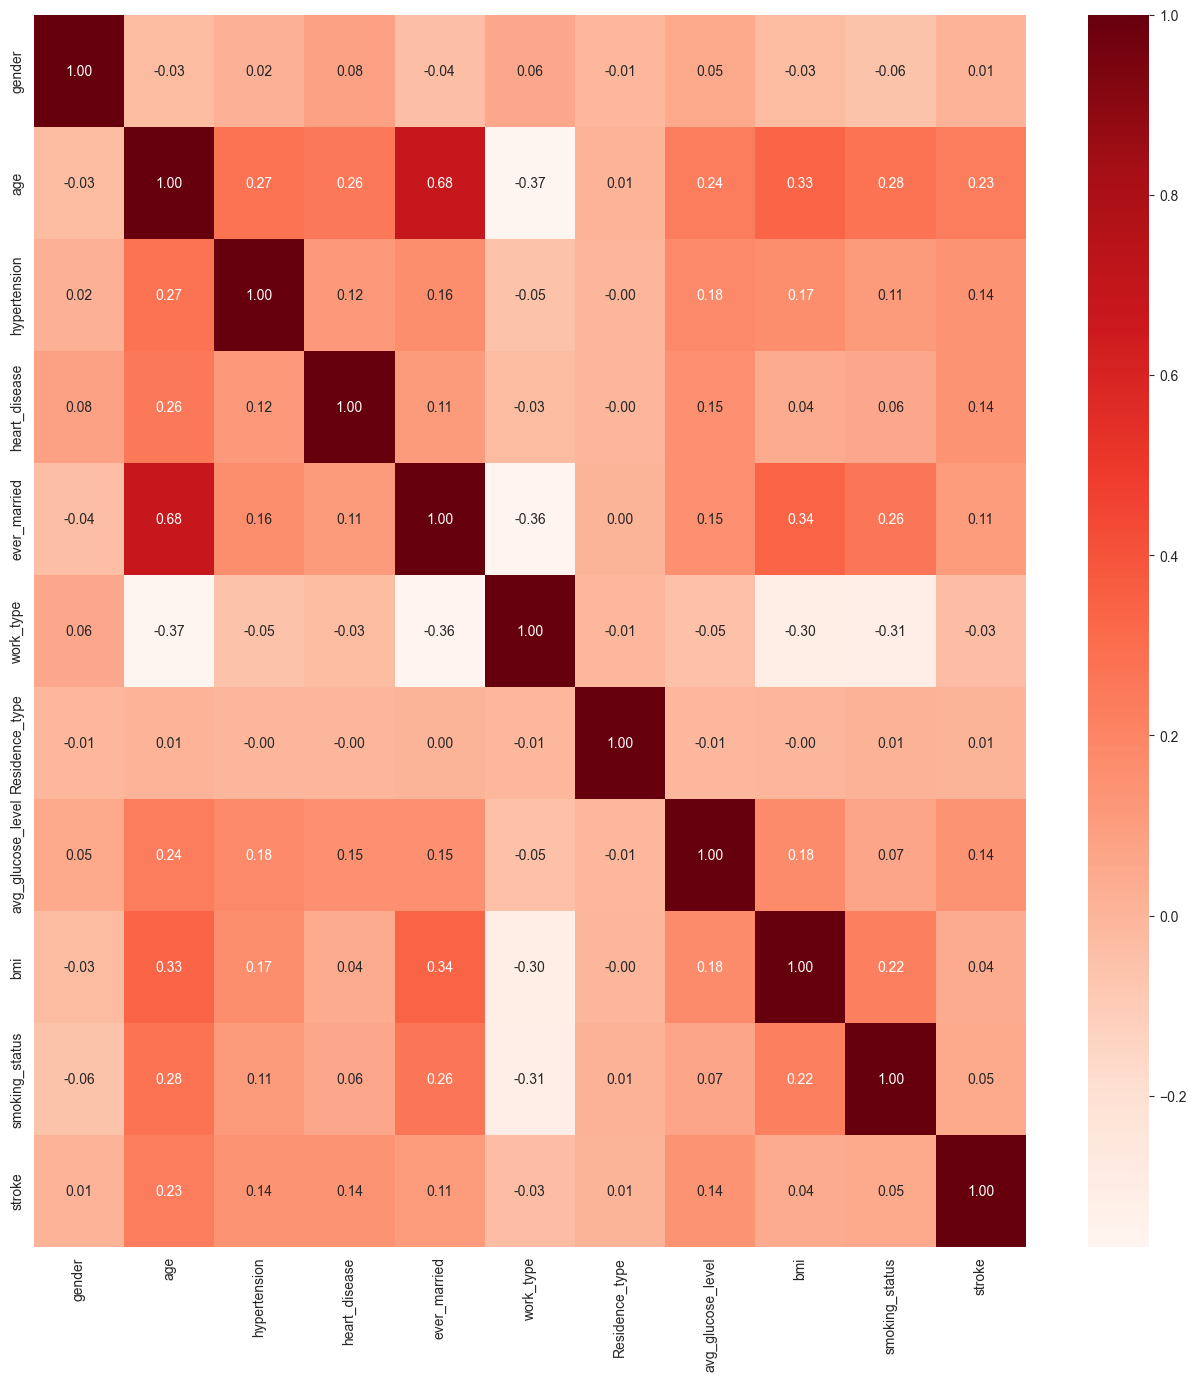

In [8]:
plt.figure(figsize=(16,16))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

Nombre d'outliers dans 'gender': 0
Nombre d'outliers dans 'age': 0
Nombre d'outliers dans 'hypertension': 451
Nombre d'outliers dans 'heart_disease': 243
Nombre d'outliers dans 'ever_married': 0
Nombre d'outliers dans 'work_type': 630
Nombre d'outliers dans 'Residence_type': 0
Nombre d'outliers dans 'avg_glucose_level': 567
Nombre d'outliers dans 'bmi': 110
Nombre d'outliers dans 'smoking_status': 0
Nombre d'outliers dans 'stroke': 209

Résumé du nombre d'outliers par colonne:
{'gender': 0, 'age': 0, 'hypertension': 451, 'heart_disease': 243, 'ever_married': 0, 'work_type': 630, 'Residence_type': 0, 'avg_glucose_level': 567, 'bmi': 110, 'smoking_status': 0, 'stroke': 209}


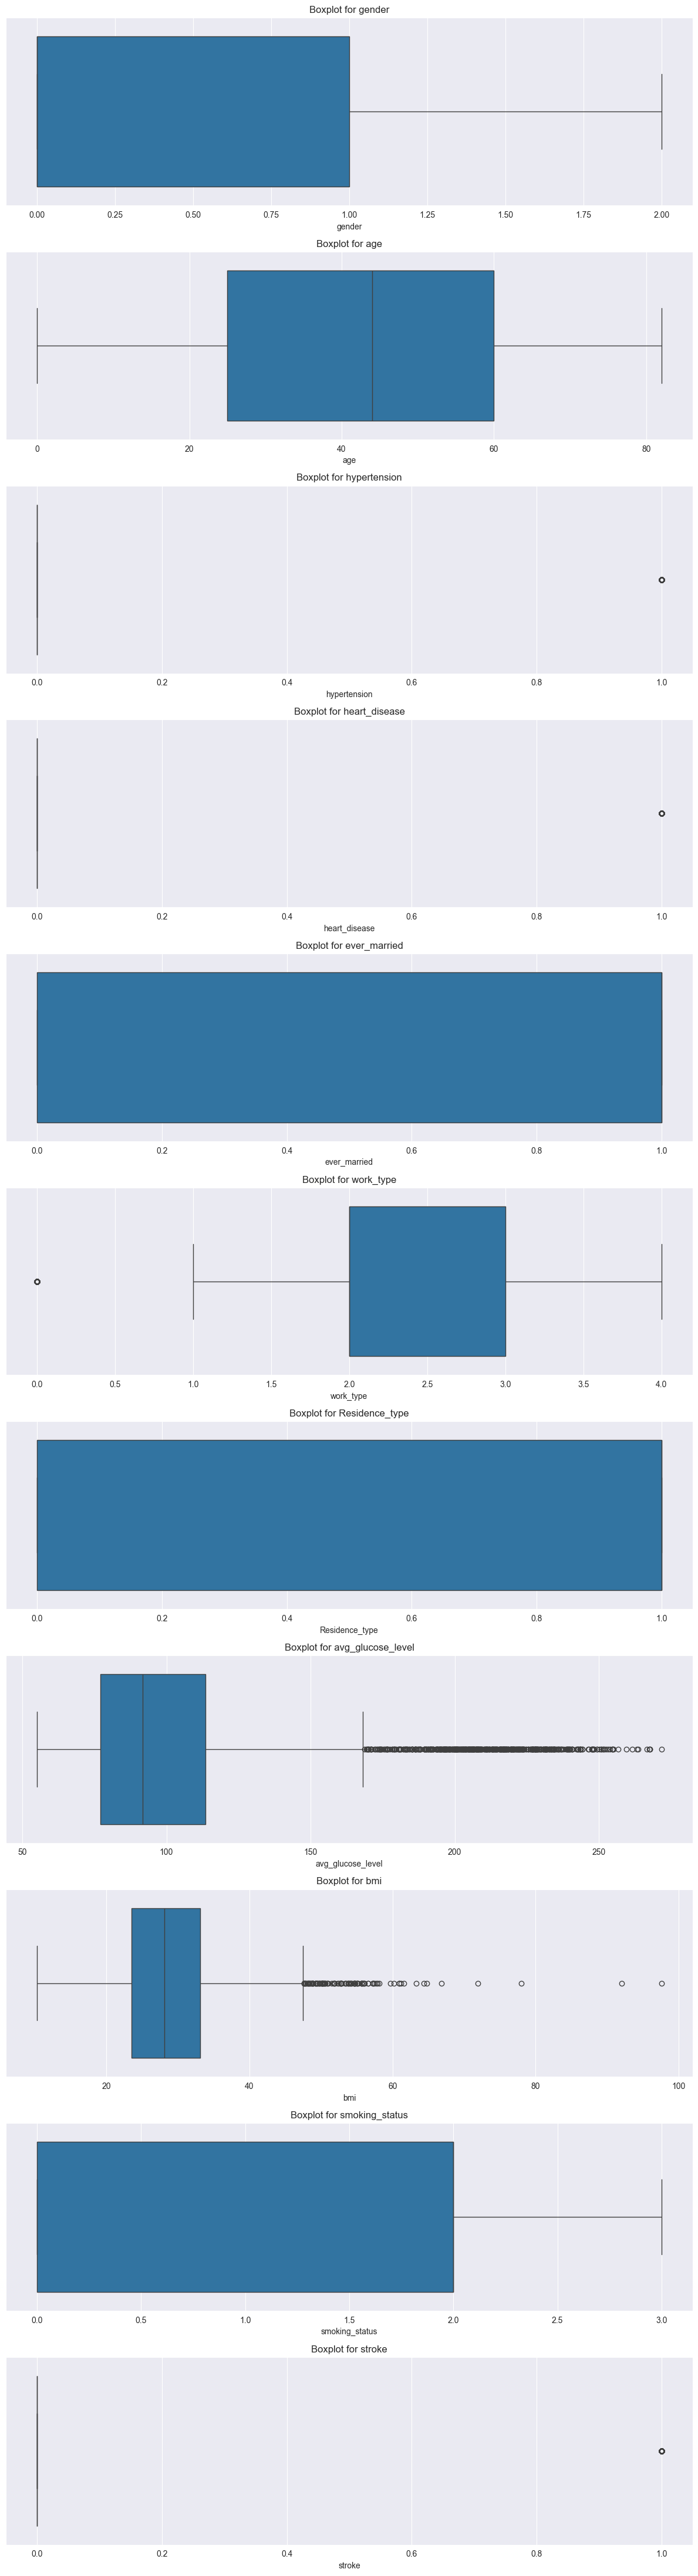

In [9]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

outliers_counts = {}

# Détection des outliers
for column in numerical_cols:
    # Calcul des quartiles et de l'IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définition des bornes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Détection des valeurs aberrantes
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Stocker le nombre d'outliers
    outliers_counts[column] = outliers.shape[0]

    # Affichage du nombre d'outliers pour cette colonne
    print(f"Nombre d'outliers dans '{column}': {outliers_counts[column]}")

# Affichage des résultats complets
print("\nRésumé du nombre d'outliers par colonne:")
print(outliers_counts)

# Affichage des boxplots pour visualiser les outliers
plt.figure(figsize=(12, len(numerical_cols) * 4))

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot for {column}')
    
plt.tight_layout()
plt.show()
   


Outliers remplacés par la médiane.


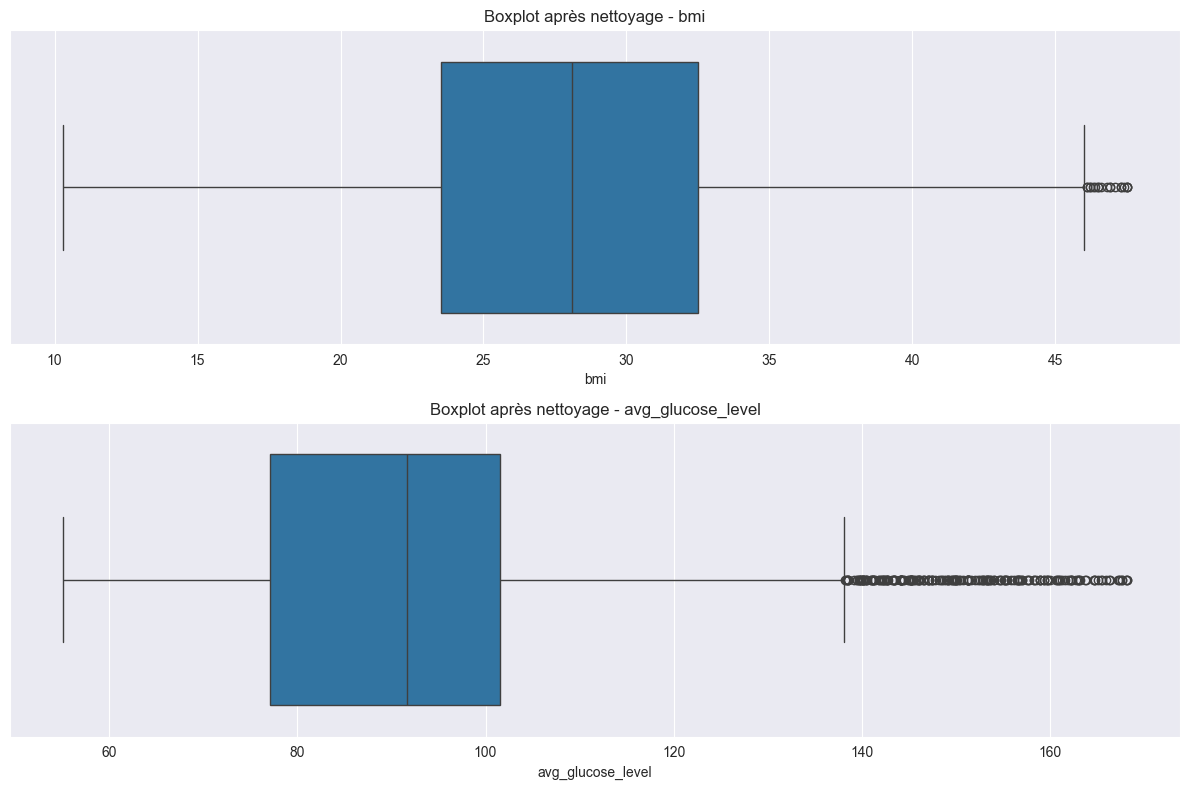

In [10]:

col_out=['bmi','avg_glucose_level']
for column in col_out:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remplacement par la médiane
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), df[column].median(), df[column])
print("Outliers remplacés par la médiane.")
plt.figure(figsize=(12, len(col_out) * 4))

for i, column in enumerate(col_out, 1):
    plt.subplot(len(col_out), 1, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot après nettoyage - {column}')
    
plt.tight_layout()
plt.show()



Outliers supprimés.


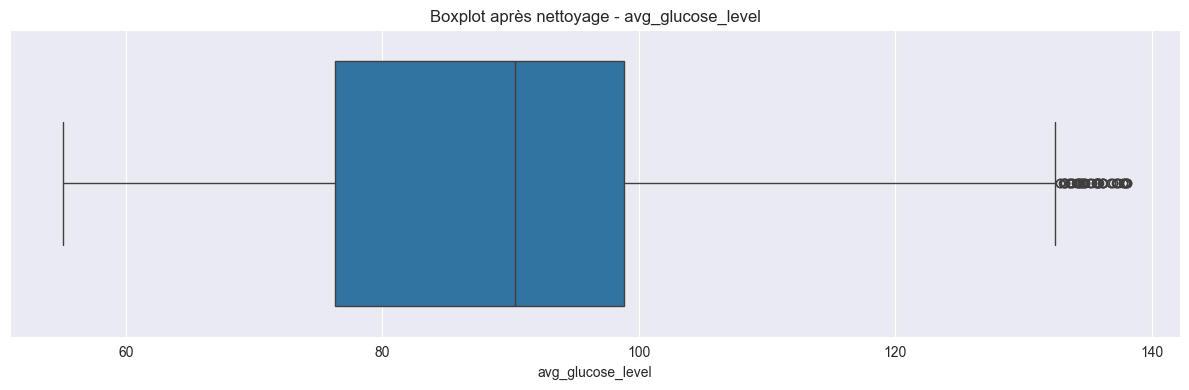

In [11]:
col_gl=['avg_glucose_level']
for column in col_gl:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
print("Outliers supprimés.")
plt.figure(figsize=(12, len(col_gl) * 4))

for i, column in enumerate(col_gl, 1):
    plt.subplot(len(col_gl), 1, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot après nettoyage - {column}')
    
plt.tight_layout()
plt.show()

In [12]:
X = df.drop(columns=["stroke"])
y = df["stroke"]
y.value_counts()
smote = SMOTE(random_state = 10)
X_resampled, Y_resampled = smote.fit_resample(X, y)
Y_resampled.value_counts()

stroke
1    4504
0    4504
Name: count, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
column_names = df.columns[:-1]
column_names

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

[LightGBM] [Info] Number of positive: 3599, number of negative: 3607
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 7206, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499445 -> initscore=-0.002220
[LightGBM] [Info] Start training from score -0.002220


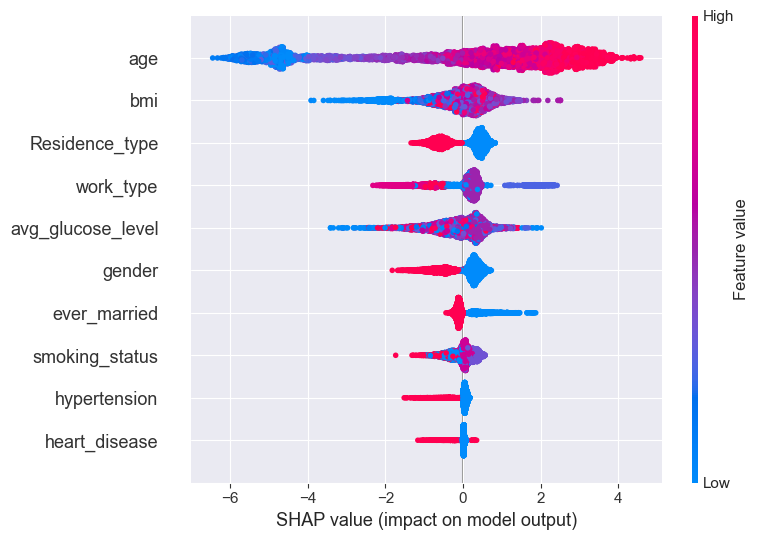

In [14]:
# LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train({'objective': 'binary'}, train_data)

# SHAP Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Résumé global
shap.summary_plot(shap_values, X_train)
#

In [0]:
# Sauvegarde dans un fichier PNG
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.savefig("../../media/feature_importance/shap_summary_plot.png", dpi=300)
plt.close()

In [16]:

# # # Combine scaled features and labels for training data
# X_train_df = pd.DataFrame(X_train_scaled, columns=column_names)
# y_train_df = pd.DataFrame(y_train, columns=["stroke"])
# train_combined = pd.concat([X_train_df, y_train_df], axis=1)
#
# # Combine scaled features and labels for test data
# X_test_df = pd.DataFrame(X_test_scaled, columns=column_names)
# y_test_df = pd.DataFrame(y_test, columns=["stroke"])
# test_combined = pd.concat([X_test_df, y_test_df], axis=1)
#
# # Save combined datasets to CSV
# train_combined.to_csv("../../media/processed/train_data_stroke.csv", index=False)
# test_combined.to_csv("../../media/processed/test_data_stroke.csv", index=False)

In [14]:
#
# from sklearn.preprocessing import StandardScaler
# import pandas as pd
#
# # Scale the entire dataset
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_resampled)
#
# # Reconstruct dataframe with column names
# column_names = df.columns[:-1]  # Assuming last column is the label
# X_df = pd.DataFrame(X_scaled, columns=column_names)
# y_df = pd.DataFrame(Y_resampled, columns=["stroke"])
#
# # Combine features and label
# combined_df = pd.concat([X_df, y_df], axis=1)
#
# # Save the full dataset (no train/test split)
# combined_df.to_csv("../../media/processed/full_data_stroke.csv", index=False)
